In [1]:
import yt
import numpy as np
ds = yt.load("Enzo_64/DD0043/data0043")

yt : [INFO     ] 2021-03-23 15:38:45,582 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2021-03-23 15:38:45,582 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2021-03-23 15:38:45,582 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-03-23 15:38:45,583 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-03-23 15:38:45,583 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-03-23 15:38:45,584 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2021-03-23 15:38:45,584 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2021-03-23 15:38:45,585 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2021-03-23 15:38:45,585 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-03-23 15:38:45,585 Parameters: hubble_constant           = 0.71


In [2]:
slc = ds.slice(0, 0.5)

In [3]:
frb = slc.to_frb(0.4, (100, 100))

In [17]:
# field values, to be element-center values
field_vals_c = frb['density']
field_vals_c = field_vals_c.ravel()
field_vals_c.shape

(10000,)

In [9]:
# in-plane coordinates
frb.buff_size


(100, 100)

In [10]:
frb.bounds

(unyt_quantity(0.3, 'code_length'),
 unyt_quantity(0.7, 'code_length'),
 unyt_quantity(0.3, 'code_length'),
 unyt_quantity(0.7, 'code_length'))

In [61]:
# in-plane coordinates. 
y_c = np.linspace(frb.bounds[0], frb.bounds[1], frb.buff_size[0])
z_c = np.linspace(frb.bounds[2], frb.bounds[3], frb.buff_size[1])
dy = y_c[1] - y_c[0]
dz = z_c[1] - z_c[0]



In [62]:
z_c.shape

(100,)

In [63]:
elements = []

In [64]:
# does not scale... whatevs, just get it working...
ny = y_c.size 
nz = z_c.size
i_el = 0
for i_zc in range(z_c.size-1):
    for i_yc in range(y_c.size-1):
        
        # global index of the vertices to add to this
        # element
        top_left = i_zc * ny + i_yc
        top_right = top_left + 1
        bot_right = top_right + ny
        bot_left = bot_right -1
                
        verts = [top_left, top_right, bot_right, bot_left]
        elements.append(verts)

In [65]:
elements[0]

[0, 1, 101, 100]

In [66]:
y_c, z_c = np.meshgrid(y_c, z_c) # element centers

In [67]:
y_c = y_c.ravel()
z_c = z_c.ravel()
x_c = np.full(x_c.shape, slc.coord)
coords = np.column_stack([x_c, y_c, z_c])

In [68]:
x_c.shape

(10000,)

In [69]:
coords[elements[0]]

unyt_array([[0.5      , 0.3      , 0.3      ],
            [0.5      , 0.3040404, 0.3      ],
            [0.5      , 0.3040404, 0.3040404],
            [0.5      , 0.3      , 0.3040404]], '(dimensionless)')

In [70]:
field_vals_c[elements[0]]




ImageArray([9.51327058e-32, 9.51327058e-32, 9.51327058e-32,
            9.51327058e-32], 'g/cm**3')

In [1]:
from yt.visualization.volume_rendering.render_source import MeshSource
from yt.utilities.lib.bounding_volume_hierarchy import BVH
import numpy as np

In [32]:
class PlaneSource(MeshSource):        
            
    def __init__(self, slice_frb, field):        
        # check that it's a frb
        # assert(slice)
#         self.frb = slice_frb
        super().__init__(slice_frb.data_source, field, engine='yt', frb = slice_frb)
        
        
    def build_volume_bvh(self):
        """

        This constructs the mesh that will be ray-traced.

        """
        ftype, fname = self.field
        
        # in-plane coordinates. 
        frb = self.frb
        buff_size = frb.buff_size
        slice_ax = self.data_source.axis 
        field_data = self.frb[self.field].d # strip units
        field_data = field_data.ravel()

        dim_1d_arrays = []
        d_dim = []
        ibuf = 0
        for idim in range(3):
            if idim != slice_ax:                
                ibuf_z = ibuf*2
                ax_coor = np.linspace(frb.bounds[ibuf_z], frb.bounds[ibuf_z+1], frb.buff_size[ibuf])
                dim_1d_arrays.append(ax_coor)  
                d_dim.append(ax_coor[1] - ax_coor[0])
                ibuf += 1
                
        # does not scale... whatevs, just get it working...
        n0 = dim_1d_arrays[0].size 
        n1 = dim_1d_arrays[1].size
        i_el = 0
        elements = []
        field_vals = []
        for i_1 in range(n1-1):
            for i_0 in range(n0-1):

                # global index of the vertices to add to this
                # element
                top_left = i_1 * n0 + i_0
                top_right = top_left + 1
                bot_right = top_right + n0
                bot_left = bot_right -1

                verts = [top_left, top_right, bot_right, bot_left]
                field_vals.append(field_data[verts])
                elements.append(verts)
        field_vals = np.array(field_vals)
        elements = np.array(elements)
        
        n0_c, n1_c = np.meshgrid(dim_1d_arrays[0], dim_1d_arrays[1]) # element centers
        n0_c = n0_c.ravel()
        n1_c = n1_c.ravel()
        
        # figure out what is x,y,z
        if slice_ax == 0:
            x_c = np.full(n0_c.shape, slc.coord)
            y_c = n0_c
            z_c = n1_c
        elif slice_ax == 1:
            x_c = n0_c
            y_c = np.full(n0_c.shape, slc.coord)
            z_c = n1_c
        elif slice_ax == 2:
            x_c = n0_c
            y_c = n1_c
            z_c = np.full(n0_c.shape, slc.coord)
                    
        coords = np.column_stack([x_c, y_c, z_c]) # vertex coordinates
                        
        
        print(field_data.shape)
        print(coords.shape)
        print(elements.shape)
        print(elements.max())
        print(elements.min())
        self.volume = BVH(coords, elements, field_vals)



In [33]:
import yt
ds = yt.load("Enzo_64/DD0043/data0043")

yt : [INFO     ] 2021-03-23 17:51:38,889 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2021-03-23 17:51:38,889 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2021-03-23 17:51:38,890 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-03-23 17:51:38,891 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-03-23 17:51:38,892 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-03-23 17:51:38,893 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2021-03-23 17:51:38,893 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2021-03-23 17:51:38,893 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2021-03-23 17:51:38,894 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-03-23 17:51:38,894 Parameters: hubble_constant           = 0.71


In [34]:
slc = ds.slice(0, 0.5)

In [35]:
slice_frb = slc.to_frb(1.,(30,30))

In [36]:
p_src = PlaneSource(slice_frb, "density")

Parsing Hierarchy : 100%|█████████▉| 751/752 [00:00<00:00, 13600.99it/s]
yt : [INFO     ] 2021-03-23 17:51:40,325 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2021-03-23 17:51:41,493 Making a fixed resolution buffer of (('gas', 'density')) 30 by 30


(900,)
(900, 3)
(841, 4)
899
0


yt : [INFO     ] 2021-03-23 17:51:47,433 Setting default field to ('gas', 'density')
yt : [INFO     ] 2021-03-23 17:51:47,457 Rendering scene (Can take a while).


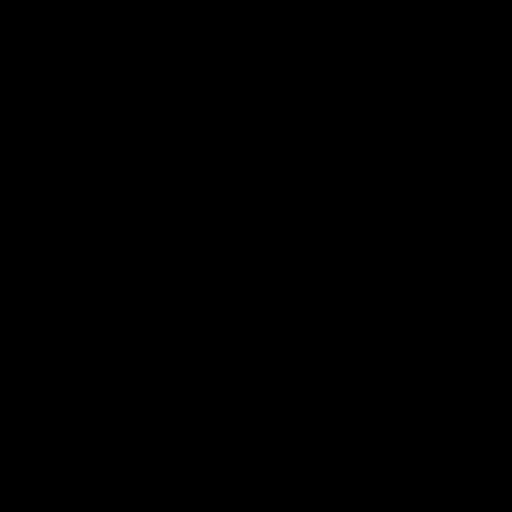

In [37]:

sc = yt.create_scene(ds, lens_type='perspective', init_sources=False)
sc.add_source(p_src)
sc.render()
sc.show()
# sc.save("../temp/helloplane.png")

# # sc = yt.create_scene(ds, lens_type='perspective', init_sources=False)
# cb = [-30,-26]
# slice = ds.slice(0,0.5)
# plane = PlaneSource(slice, 'density', color_bounds=cb, logfield=True, alpha=1)
# sc.add_source(plane)
# # slice = ds.slice(0,0.65)
# plane = PlaneSource(slice, 'density', color_bounds=cb, logfield=True, alpha=1)
# sc.add_source(plane)

